# <div style="color:green">[Scripts] Détecter les bad buzz - analyse</div>

<img src="img/flight_logo.png" style="height=300px">

# <div id="ch0" style="color: blue">0. Plan du notebook</div>

1. [Imports](#ch1)<br><br>
2. [Analyse et nettoyage](#ch2)<br><br>
3. [Baseline](#ch3)<br>
>3.1 [API sur étagère : MicroSoft Language Services](#ch3_1)<br>
>3.2 [Bag of Words : TF-IDF & LinearRegression](#ch3_2)<br>

# <div id="ch1" style="color: blue">1. Imports</div>

### Imports bilbiothèques

In [1]:
import gc
import os
import re
import sys
import nltk
import time
import gensim
import langid
import string
import chardet
import requests
import contractions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import urllib
import joblib
from urllib.error import HTTPError
from urllib.parse import quote
from urllib.parse import urlencode
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from gensim import corpora
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS
from gensim.models.phrases import Phraser
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.models import save_model
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.layers import GRU

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aledo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aledo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aledo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Fonctions

In [361]:
def plot_acc_loss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    los = hist.history['loss']
    val_los = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(15, 5))
    #Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    #Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, los, '-', label='Training Loss')
    plt.plot(epochs, val_los, ':', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.show()

### Import du fichier csv brut

In [7]:
with open('data/training.1600000.processed.noemoticon.csv', 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large
tw = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding=enc['encoding'])

In [10]:
tw.shape

(1599999, 6)

In [8]:
tw.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


<div class='alert alert-block alert-info'>
    
On s'aperçoit qu'il n'y a pas d'en-têtes et que la première ligne de données a été prise à tort pour remplir ce rôle.
    
</div>

[*(Retour Sommaire)*](#ch0)

# <div id="ch2" style="color: blue">2. Analyse et nettoyage</div>

### Ajout de titre de colonnes et récupération de la première ligne de données

In [14]:
first_line = tw.columns.to_list()

In [26]:
tw.columns = ['tw_y', 'tw_id', 'tw_date', 'tw_query', 'tw_author', 'tw_text']

In [28]:
tweets = pd.concat([pd.DataFrame([first_line], columns=['tw_y', 'tw_id', 'tw_date', 'tw_query', 'tw_author', 'tw_text']), tw], ignore_index=True)

In [45]:
tweets.shape

(1600000, 6)

In [29]:
tweets.head()

,tw_y,tw_id,tw_date,tw_query,tw_author,tw_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [30]:
tweets.describe(include='all')

,tw_y,tw_id,tw_date,tw_query,tw_author,tw_text
count,1600000,1600000,1600000,1600000,1600000,1600000
unique,3,1598315,774363,1,659775,1581466
top,4,2190457769,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,800000,2,20,1600000,549,210


<div class='alert alert-block alert-info'>
    
3 catégories sont manifestement présentes, regardons les valeurs uniques.
    
</div>

### Aperçu des catégories

In [42]:
tweets['tw_y'].unique()

array(['0', 0, 4], dtype=object)

<div class='alert alert-block alert-info'>
    
Il n'y a en réalité que 2 catégories : les 0 ont été écrits tantôt en nombre tantôt sous forme de texte.
    
</div>

In [43]:
tweets['tw_y'].replace(to_replace='0', value=0, inplace=True)
tweets['tw_y'].unique()

array([0, 4], dtype=int64)

In [44]:
print('Nombre de tweets par catégorie :')
print('------------------------------')
tweets[['tw_y', 'tw_id']].groupby('tw_y').count().reset_index()

Nombre de tweets par catégorie :
------------------------------


,tw_y,tw_id
0,0,800000
1,4,800000


<div class='alert alert-block alert-info'>
    
Les classes sont équilibrées, pour l'instant...
    
</div>

### Sentiment associé à chaque catégorie

In [46]:
print('Catégorie 0 :')
print('-----------')
tweets[tweets['tw_y'] == 0].head()

Catégorie 0 :
-----------


,tw_y,tw_id,tw_date,tw_query,tw_author,tw_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [47]:
print('Catégorie 4 :')
print('-----------')
tweets[tweets['tw_y'] == 4].head()

Catégorie 4 :
-----------


,tw_y,tw_id,tw_date,tw_query,tw_author,tw_text
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


<div class='alert alert-block alert-info'>
    
Nous parvenons ainsi à déterminer que parmis nos 2 classes :
- **La classe 0** est attribuée a des tweets exprimant des sentiments **négatifs**
- **La classe 4** est attribuée a des tweets exprimant des sentiments **positifs**
    
</div>

### Rationalisation du dataset

Nous n'allons conserver que les seules colonnes nécessaire à notre analyse : le texte et la classe

In [52]:
tweets.to_csv(path_or_buf='data/tw_brut.csv', index=False)

In [53]:
#tweets = pd.read_csv('data/tw_brut.csv')

In [54]:
tw = tweets[['tw_y', 'tw_text']]

In [55]:
tw.head()

,tw_y,tw_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [56]:
del tweets
gc.collect()

52905

In [57]:
tw.to_csv(path_or_buf='data/tw_light.csv', index=False)

In [3]:
tw = pd.read_csv('data/tw_light.csv')

### Détection de la langue

In [4]:
tw['language'] = tw['tw_text'].apply(lambda x: langid.classify(x)[0])

In [61]:
print('Langues détectées :')
print('-----------------')
for l in tw['language'].unique():
    print(f"{l}\t :: {tw[tw['language'] == l].shape[0]} occurrences")

Langues détectées :
-----------------
en	 :: 1520987 occurrences
es	 :: 6805 occurrences
eu	 :: 899 occurrences
sv	 :: 2413 occurrences
de	 :: 10118 occurrences
fr	 :: 4896 occurrences
fi	 :: 1808 occurrences
da	 :: 3038 occurrences
id	 :: 4057 occurrences
it	 :: 6489 occurrences
lv	 :: 237 occurrences
nl	 :: 5448 occurrences
xh	 :: 370 occurrences
bs	 :: 183 occurrences
et	 :: 1853 occurrences
no	 :: 1847 occurrences
mt	 :: 1909 occurrences
cy	 :: 2298 occurrences
cs	 :: 428 occurrences
mg	 :: 635 occurrences
el	 :: 99 occurrences
ms	 :: 922 occurrences
sl	 :: 820 occurrences
pl	 :: 3483 occurrences
sw	 :: 1408 occurrences
la	 :: 1174 occurrences
af	 :: 1150 occurrences
zh	 :: 737 occurrences
pt	 :: 2349 occurrences
qu	 :: 257 occurrences
tl	 :: 1567 occurrences
br	 :: 1178 occurrences
tr	 :: 336 occurrences
oc	 :: 107 occurrences
hy	 :: 88 occurrences
vi	 :: 585 occurrences
ky	 :: 114 occurrences
az	 :: 352 occurrences
an	 :: 88 occurrences
ga	 :: 306 occurrences
hu	 :: 482 occurrenc

Nombre de langues différentes détectées :

In [62]:
len(tw['language'].unique())

73

In [5]:
tw_en = tw[tw['language'] =='en']

In [64]:
print(f"Les tweets en langue anglaise représentent {np.round(tw_en.shape[0] * 100 / 1600000, 2)}% des lignes du dataset")

Les tweets en langue anglaise représentent 95.06% des lignes du dataset


<div class='alert alert-block alert-info'>
    
Les tweets de notre dataset ont été écrits dans **73 langues différentes**.<br>
Nous nous concentrerons dans cette étude sur les commentaires en **langue anglaise**, largement majoritaires avec plus de **95%** du total des tweets à notre disposition.
    
</div>

In [6]:
tw_en.to_csv(path_or_buf='data/tw_english.csv', index=False)

In [7]:
#tw_en = pd.read_csv('data/tw_english.csv')

In [9]:
tw_en.shape

(1520987, 3)

In [10]:
tw_en.head()

,tw_y,tw_text,language
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",en
1,0,is upset that he can't update his Facebook by ...,en
2,0,@Kenichan I dived many times for the ball. Man...,en
3,0,my whole body feels itchy and like its on fire,en
4,0,"@nationwideclass no, it's not behaving at all....",en


In [70]:
print('Nombre de commentaires en langue anglaise par classe :')
print('----------------------------------------------------')
nb_0 = tw_en[tw_en['tw_y'] == 0].shape[0]
nb_4 = tw_en[tw_en['tw_y'] == 4].shape[0]
print(f"Commentaires négatifs (classe 0) : {nb_0} lignes")
print(f"Commentaires positifs (classe 4): {nb_4} lignes")
print(f"Différence : {np.abs(nb_0 - nb_4)} lignes en plus pour la catégorie '{0 if nb_0 > nb_4 else 4}'")

Nombre de commentaires en langue anglaise par classe :
----------------------------------------------------
Commentaires négatifs (classe 0) : 763863 lignes
Commentaires positifs (classe 4): 757124 lignes
Différence : 6739 lignes en plus pour la catégorie '0'


<div class='alert alert-block alert-info'>
    
Nous voyons que les classes ne sont à présent plus équilibrées : la **classe 0** comporte à présent **6739 enregistrements en plus**.<br>
Pour remédier à cela, nous échantillonnerons plus de commentaires négatifs dans le jeu de test et équlibrerons les jeux d'entraînement uniquement.
    
</div>

### Fréquence des termes

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [10]:
def normalize_text(s):
    s = re.sub('\@\w+', '', s) # Enlèvement des références à d'autres utilisateurs
    s = re.sub('http(s)?[:\/\.\w-]+', '', s) # Enlèvement des URL
    s = re.sub('[^a-zA-Z]', ' ', s) # Enlèvement des caractères hors lettres
    s = s.lower() # Ajustement de la casse
    s = ' '.join([contractions.fix(word) for word in s.split()]) # Expension des contractions
    s = ' '.join([lemmatizer.lemmatize(word) for word in s.split() if not word in set(stopwords)]) # Enlèvement des stop words et lemmatisation
    return s

In [11]:
tw_en['normalized'] = tw_en['tw_text'].apply(normalize_text)

In [490]:
tw_en_sup = tw_en.dropna(subset='normalized', axis=0)

In [39]:
def get_most_frequent_words(ser, min_ngram, max_ngram):
    vectorizer = CountVectorizer(ngram_range=(min_ngram, max_ngram))
    X = vectorizer.fit_transform(ser)
    wd_matrix = pd.DataFrame(
        X.toarray(), columns=vectorizer.get_feature_names_out()).transpose().sum(axis=1).sort_values(ascending=False)
    res = pd.DataFrame(columns=['ngram', 'occurrences'])
    res['ngram'] = wd_matrix.index
    res['occurrences'] = wd_matrix.values
    return res

In [40]:
def ngrams_by_chunks(ser, min_ngram, max_ngram):
    len_ser = len(ser)
    left_value = -2000
    right_value = 0
    chunks = pd.DataFrame(columns=['ngram', 'occurrences'])
    while right_value < len_ser:
        left_value += 2000
        right_value = min(right_value + 2000, len_ser)
        chunks = pd.concat([chunks, get_most_frequent_words(ser.iloc[left_value:right_value], min_ngram, max_ngram)], ignore_index=True)
    res = chunks.groupby('ngram').sum().sort_values(by='occurrences', ascending=False).reset_index()
    return res

In [41]:
print('Mots les plus fréquents dans les tweets positifs :')
print('------------------------------------------------')
ngrams_by_chunks(tw_en_sup.loc[tw_en_sup['tw_y'] == 4, 'normalized'], 1, 1).head(20)

Mots les plus fréquents dans les tweets positifs :
------------------------------------------------


,ngram,occurrences
0,good,59261
1,day,55094
2,love,48916
3,quot,44566
4,going,41725
5,get,37761
6,like,37308
7,thanks,35468
8,lol,34799
9,time,33730


In [42]:
print('Mots les plus fréquents dans les tweets négatifs :')
print('------------------------------------------------')
ngrams_by_chunks(tw_en_sup.loc[tw_en_sup['tw_y'] == 0, 'normalized'], 1, 1).head(20)

Mots les plus fréquents dans les tweets négatifs :
------------------------------------------------


,ngram,occurrences
0,day,50986
1,get,47159
2,going,46994
3,work,45772
4,want,44769
5,like,40549
6,got,37906
7,today,37647
8,back,32562
9,really,31740


In [43]:
print('Bigrammes les plus fréquents dans les tweets positifs :')
print('-----------------------------------------------------')
ngrams_by_chunks(tw_en_sup.loc[tw_en_sup['tw_y'] == 4, 'normalized'], 2, 2).head(20)

Bigrammes les plus fréquents dans les tweets positifs :
-----------------------------------------------------


,ngram,occurrences
0,good morning,7433
1,last night,4972
2,good luck,3547
3,cannot wait,3438
4,looking forward,3429
5,good night,3408
6,happy birthday,3177
7,good day,2901
8,let know,2886
9,great day,2794


In [44]:
print('Bigrammes les plus fréquents dans les tweets négatifs :')
print('-----------------------------------------------------')
ngrams_by_chunks(tw_en_sup.loc[tw_en_sup['tw_y'] == 0, 'normalized'], 2, 2).head(20)

Bigrammes les plus fréquents dans les tweets négatifs :
-----------------------------------------------------


,ngram,occurrences
0,last night,7541
1,feel like,6256
2,wish could,6120
3,look like,4354
4,going miss,3127
5,really want,3066
6,last day,2802
7,back work,2613
8,sorry hear,2463
9,looking forward,2198


### Taille du vocabulaire

In [177]:
uni = ngrams_by_chunks(tw_en['normalized'], 1, 1)

In [178]:
uni.describe(include='all')

,ngram,occurrences
count,239271,239271.000000
unique,239271,NaN
top,day,NaN
freq,1,NaN
mean,NaN,42.555161
std,NaN,847.805751
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,1.000000
75%,NaN,3.000000


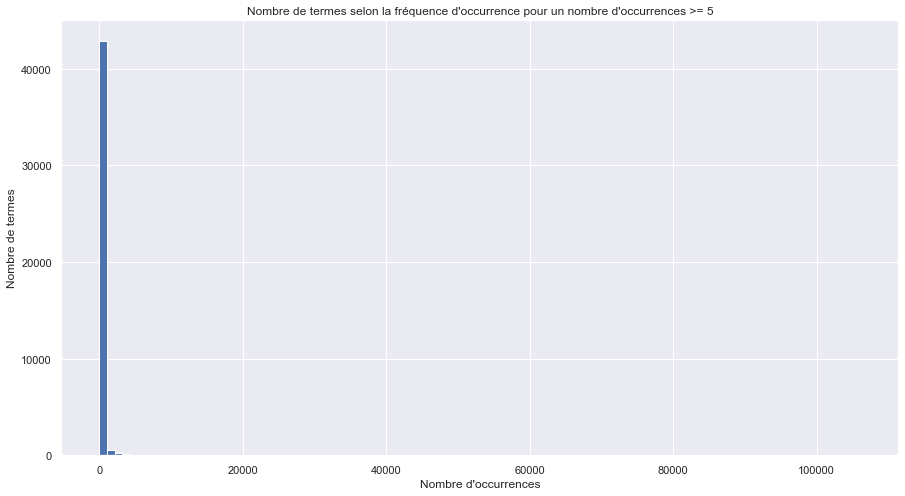

In [200]:
plt.figure(figsize=(15, 8))
plt.hist(uni.loc[uni['occurrences'] > 4, 'occurrences'], bins=100)
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Nombre de termes")
plt.title("Nombre de termes selon la fréquence d'occurrence pour un nombre d'occurrences >= 5")
plt.show()

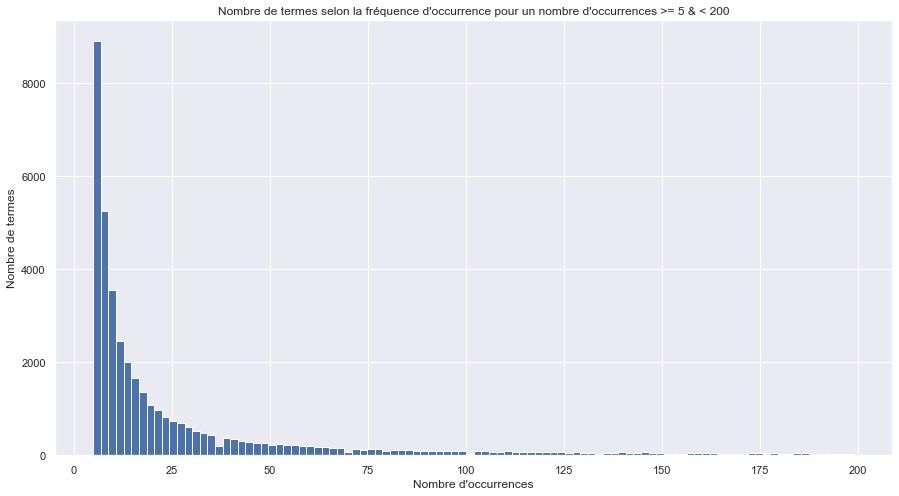

In [201]:
plt.figure(figsize=(15, 8))
plt.hist(uni.loc[(uni['occurrences'] > 4) & (uni['occurrences'] < 200), 'occurrences'], bins=100)
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Nombre de termes")
plt.title("Nombre de termes selon la fréquence d'occurrence pour un nombre d'occurrences >= 5 & < 200")
plt.show()

In [199]:
print(f"Nombre de termes apparaissant au moins 5 fois : {len(uni.loc[uni['occurrences'] > 4, 'occurrences'])}")

Nombre de termes apparaissant au moins 5 fois : 44157


In [202]:
print(f"Nombre de termes apparaissant entre 5 et 200 fois : {len(uni.loc[(uni['occurrences'] > 4) & (uni['occurrences'] < 201), 'occurrences'])}")

Nombre de termes apparaissant entre 5 et 200 fois : 39777


<div class='alert alert-block alert-info'>
    
Nous constatons qu'une bonne taille de vocabulaire à considérer serait de <b>40,000</b> mots.
    
</div>

### Longueur des tweets en nombre de caractères

In [491]:
tw_en['lng'] = tw_en['normalized'].apply(lambda x: len(x))

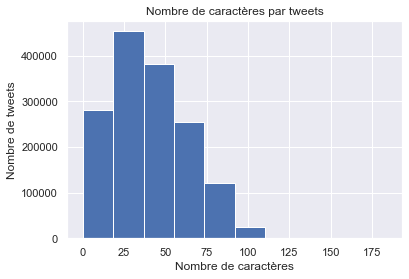

In [170]:
plt.figure()
plt.hist(tw_en['lng'])
plt.xlabel('Nombre de caractères')
plt.ylabel('Nombre de tweets')
plt.title('Nombre de caractères par tweets')
plt.show()

### Longueur des tweets en nombre de mots

In [492]:
tw_en['lng'] = tw_en['normalized'].apply(lambda x: len(x.split(' ')))

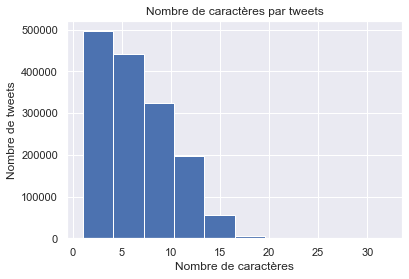

In [172]:
plt.figure()
plt.hist(tw_en['lng'])
plt.xlabel('Nombre de caractères')
plt.ylabel('Nombre de tweets')
plt.title('Nombre de caractères par tweets')
plt.show()

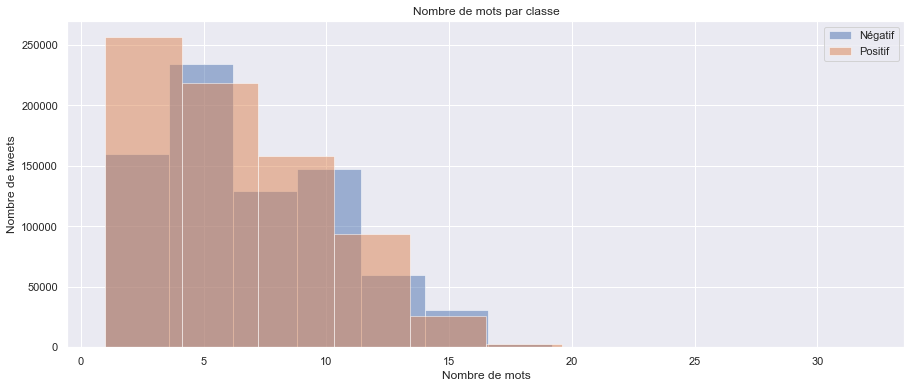

In [166]:
plt.figure(figsize=(15, 6))
plt.hist(tw_en.loc[tw_en['tw_y'] == 0, 'lng'], alpha=0.5, label='Négatif')
plt.hist(tw_en.loc[tw_en['tw_y'] == 4, 'lng'], alpha=0.5, label='Positif')
plt.legend()
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de tweets')
plt.title('Nombre de mots par classe')
plt.show()

In [173]:
tw_en.head()

,tw_y,tw_text,language,normalized,lng
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",en,awww bummer shoulda got david carr third day,8
1,0,is upset that he can't update his Facebook by ...,en,upset update facebook texting might cry result...,11
2,0,@Kenichan I dived many times for the ball. Man...,en,dived many time ball managed save rest bound,8
3,0,my whole body feels itchy and like its on fire,en,whole body feel itchy like fire,6
4,0,"@nationwideclass no, it's not behaving at all....",en,behaving mad see,3


### Sauvegarde des données normalisées

In [493]:
tw_en.to_csv('data/tw_normalized.csv', index=False)

In [3]:
#tw_en = pd.read_csv('data/tw_normalized.csv')

[*(Retour Sommaire)*](#ch0)

# <div id="ch3" style="color: blue">3. Baseline</div>

Afin de conclure notre analyse et d'introduire la phase de recherche de modèle, nosu allons ici effectuer des essais avec deux baselines:
<ul>
    <li>l'API sur étagère Microsoft Language Services</li>
    <li>Une méthode bag-of-words : classification par regression logistique en sortie d'un TF-IDF</li>
</ul>

### Split train / test

Séparation jeux d'entraînement (90%) et test (10%) en données `X` et labels `y`

In [5]:
#Nous remplaçons la valeur de classe positive 4 par 1 afin de faciliter la transformation en catégorielle binaire
tw_en['tw_y'].replace(to_replace=4, value=1, inplace=True)

In [6]:
tw_pos = tw_en.loc[tw_en['tw_y'] == 1, ['normalized', 'tw_y']]
tw_neg = tw_en.loc[tw_en['tw_y'] == 0, ['normalized', 'tw_y']]
tw_pos_train = tw_pos.head(680000)
tw_pos_test = tw_pos.tail(tw_pos.shape[0] - 680000)
tw_neg_train = tw_neg.head(680000)
tw_neg_test = tw_neg.tail(tw_neg.shape[0] - (680000))
X_train = np.concatenate((tw_pos_train['normalized'], tw_neg_train['normalized']))
X_test = np.concatenate((tw_pos_test['normalized'], tw_neg_test['normalized']))
y_train = np.concatenate((tw_pos_train['tw_y'], tw_neg_train['tw_y']))
y_test = np.concatenate((tw_pos_test['tw_y'], tw_neg_test['tw_y']))

In [240]:
print(f"Taille du jeu d'entraînement : X={np.shape(X_train)} y={np.shape(y_train)}")
print(f"Taille du jeu de test : X={np.shape(X_test)} y={np.shape(y_test)}")

Taille du jeu d'entraînement : X=(1360000,) y=(1360000,)
Taille du jeu de test : X=(160987,) y=(160987,)


### Tokenisation

In [7]:
MAX_LEN = tw_en['lng'].max()  #Taille maximale des tweets du dataset
TOP_WORDS = 40000  #Taille du vocabulaire trouvée au chapitre précédent

In [ ]:
tokenizer = Tokenizer(num_words=TOP_WORDS)
tokenizer.fit_on_texts(X_train)

Post-Padding des sequences tokenisées

In [77]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=MAX_LEN)
    return padded

In [243]:
X_train_padded = get_sequences(tokenizer, X_train)
X_test_padded = get_sequences(tokenizer, X_test)

In [244]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

## <div id="ch3_1" style="color: orange">3.1 API sur étagère : MicroSoft Language Services</div>

### Code d'appel à l'API

In [417]:
# Source https://docs.microsoft.com/en-us/azure/cognitive-services/language-service/sentiment-opinion-mining/quickstart?pivots=programming-language-python

In [433]:
api_key = '17607ed7f7b045c9a939fea5c88c85b0'
endpoint = 'https://p7-sentiments.cognitiveservices.azure.com/'

In [419]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

In [423]:
# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(api_key)
    text_analytics_client = TextAnalyticsClient(endpoint=endpoint, credential=ta_credential)
    return text_analytics_client

In [434]:
client = authenticate_client()

### Récupération de la base de test

In [427]:
ms_examples = pd.read_csv('data/tw_ms.csv')

In [428]:
ms_examples.head()

,tw_y,normalized
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save rest bound
3,0,whole body feel itchy like fire
4,0,behaving mad see


In [440]:
print(f"Nombre d'exemples à notre disposition : {ms_examples.shape[0]}")

Nombre d'exemples à notre disposition : 400


<div class='alert alert-block alert-info'>
    
Nous ne testons l'API que sur un nombre restreint d'exemples afin de ne pas déclencher des coûts supérieurs à ceux du crédit offert dans le cadre de l'essai gratuit Azure.
    
</div>

### Test de l'API sur un exemple

In [436]:
def sentiment_analysis_example(client, document, y_label):
    response = client.analyze_sentiment(documents=[document])[0]
    print(f"Predicted Sentiment: {response.sentiment} (POS={response.confidence_scores.positive} "\
          f"NEU={response.confidence_scores.neutral} NEG={response.confidence_scores.negative}) :: "\
          f"True Label: {'Positive' if y_label == 1 else 'Negative'}")

In [437]:
sentiment_analysis_example(client, ms_examples.loc[0, 'normalized'], ms_examples.loc[0, 'tw_y'])

Predicted Sentiment: negative (POS=0.02 NEU=0.01 NEG=0.97) :: True Label: Negative


<div class='alert alert-block alert-info'>
    
Nous constatons que l'API Azure ne correspond pas exactement à nos souhaits, car elle prédit 3 sentiments au lieu de seulement 2 (présence du neutre).<br>
Ainsi nous devons faire un choix de répartition du neutre : nous choisissons ici de considérer que neutre = négatif afind e ne pas rater de bad buzz.
    
</div>

### Test de l'API sur toute la base d'exemple

In [450]:
def sentiment_analysis_test(client, df):
    res = []
    for idx, row in df.iterrows():
        response = client.analyze_sentiment(documents=[df.loc[idx, 'normalized']])[0]
        if response.sentiment == 'positive':
            res.append(1)
        else:
            res.append(0)
    return res

In [456]:
tps1 = time.time()
ms_anwsers = sentiment_analysis_test(client, ms_examples)
tps2 = time.time()

### Scores

In [471]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [457]:
print("Matrice de confusion")
print("--------------------")
confusion_matrix(ms_examples['tw_y'], ms_anwsers)

Matrice de confusion
--------------------


array([[155,  45],
       [ 89, 111]], dtype=int64)

In [484]:
print(f"Accuracy : {accuracy_score(ms_examples['tw_y'], ms_anwsers)}")
print(f"Rappel : {recall_score(ms_examples['tw_y'], ms_anwsers)}")
print(f"AUC : {roc_auc_score(ms_examples['tw_y'], ms_anwsers)}")

Accuracy : 0.665
Rappel : 0.555
AUC : 0.6650000000000001


In [460]:
print(f"Temps total d'exécution : {np.round(tps2 - tps1, 2)} secondes")
print('-----------------------')

Temps total d'exécution : 43.41 secondes
-----------------------


<div class='alert alert-block alert-info'>
    
Les scores sont très mauvais, à peine meilleur qu'une classification aléatoire.
    
</div>

[*(Retour Sommaire)*](#ch0)

## <div id="ch3_2" style="color: orange">3.2 Bag of Words : TF-IDF & LogisticRegression</div>

In [320]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=TOP_WORDS)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [328]:
log = LogisticRegression(random_state=11, max_iter=300)
cv = StratifiedKFold()
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(log, param_grid=params, cv=cv, scoring='accuracy')

In [329]:
tps1 = time.time()
grid.fit(X_train_tfidf, y_train)
tps2 = time.time()

C:\Users\aledo\anaconda3\envs\p7\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aledo\anaconda3\envs\p7\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C:\Users\aledo\anaconda3\envs\p7\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [330]:
print(f"Temps total d'exécution : {np.round(tps2 - tps1, 2)} secondes")

Temps total d'exécution : 1988.88 secondes


In [331]:
log_fit = grid.best_estimator_
y_pred_tfidf = log_fit.predict(X_test_tfidf)

In [332]:
print(confusion_matrix(y_test, y_pred_tfidf))

[[64484 19379]
 [17069 60055]]


In [334]:
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     83863
           1       0.76      0.78      0.77     77124

    accuracy                           0.77    160987
   macro avg       0.77      0.77      0.77    160987
weighted avg       0.77      0.77      0.77    160987



In [472]:
print(f"Accuracy : {accuracy_score(y_test, y_pred_tfidf)}")
print(f"Recall : {recall_score(y_test, y_pred_tfidf)}")
print(f"AUC : {roc_auc_score(y_test, y_pred_tfidf)}")

Accuracy : 0.7735966258145067
Recall : 0.7786810850059644
AUC : 0.7738009123919678


<div class='alert alert-block alert-info'>
    
Cette fois nous avons une bonne baseline : la prédiction tombe juste 3 fois sur 4.<br>
Ces résultats préliminaires serviront de base de comparaison pour les modèles développés dans le second notebook.
    
</div>

[*(Retour Sommaire)*](#ch0)